# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "bit_fingerprint_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,0.528940
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,3.696159
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,2.058614
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,3.045117
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,3.452355


In [8]:
compare_data.shape

(2067, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,2.459563,17.889205
478,Cc1[nH]c(=O)c(CC(O)NC(Cc2cn(C(=O)OCc3ccccc3)c3...,5.66,2.019374,13.254155
223,O=C1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(...,5.41,1.893417,12.366359
1699,CCCCCCCCCCCCCCO,6.03,2.928715,9.617967
1770,Clc1c(Cl)c(Cl)c2c(oc3c(Cl)c(Cl)c(Cl)c(Cl)c32)c1Cl,8.60,5.531763,9.414080


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1648,CCCC(=O)OCC(Cc1cncn1C)C(CC)C(=O)OCc1ccccc1,3.78,3.780033,1.083752e-09
1427,CC(C)C(=O)Nc1cc(Cl)ccc1S(N)(=O)=O,1.87,1.870188,3.528984e-08
1933,N#CC(=NOCC1OCCO1)c1ccccc1,2.76,2.760343,1.176452e-07
1395,CCCCC(OC(Cc1ccccc1)C(=O)N1CCC(OCOC)CC1)C(=O)NC...,4.20,4.200467,2.178578e-07
1864,CCOC(=O)CN(C(=O)CCl)c1ccccc1OC(C)C,2.75,2.749396,3.647006e-07


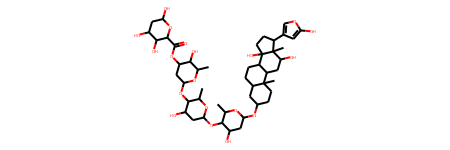

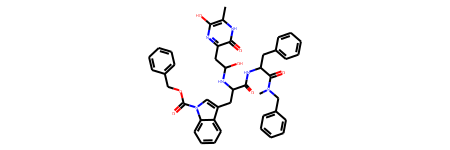

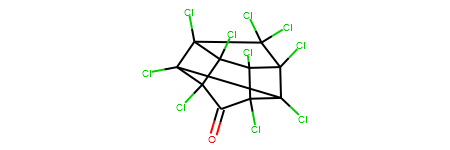

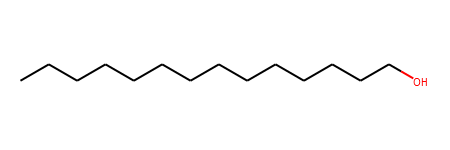

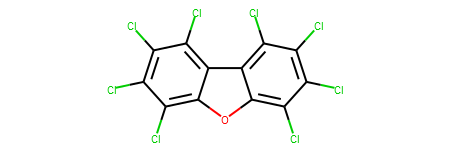

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

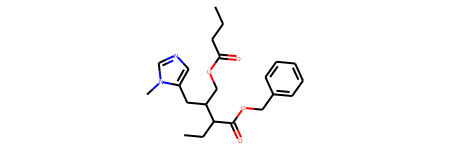

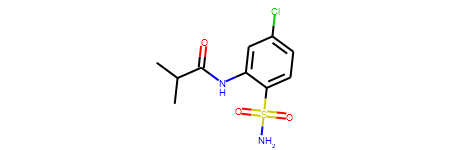

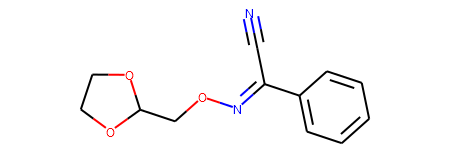

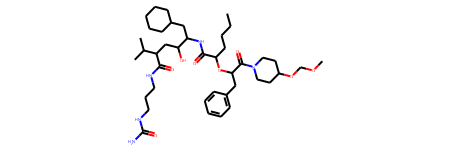

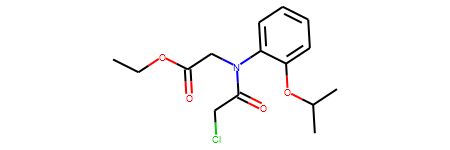

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1648,CCCC(=O)OCC(Cc1cncn1C)C(CC)C(=O)OCc1ccccc1,3.78,3.780033,1.083752e-09,25,1,5,20.000000,1,100.0,29,11,37.931034,False
1427,CC(C)C(=O)Nc1cc(Cl)ccc1S(N)(=O)=O,1.87,1.870188,3.528984e-08,29,4,2,6.896552,2,50.0,17,6,35.294118,False
1933,N#CC(=NOCC1OCCO1)c1ccccc1,2.76,2.760343,1.176452e-07,20,1,0,0.000000,1,100.0,18,6,33.333333,False
1395,CCCCC(OC(Cc1ccccc1)C(=O)N1CCC(OCOC)CC1)C(=O)NC...,4.20,4.200467,2.178578e-07,10,1,0,0.000000,0,0.0,56,6,10.714286,False
1864,CCOC(=O)CN(C(=O)CCl)c1ccccc1OC(C)C,2.75,2.749396,3.647006e-07,10,1,0,0.000000,1,100.0,21,6,28.571429,False


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,1.932932,1.938062,1.409173e-02,17.641838,1.836767,0.879556,5.278018,0.958796,55.269414,17.388273,7.779715,46.315346
std,1.526782,1.521785,1.222793e-02,7.468139,1.145167,1.321883,7.899004,0.750586,40.636987,7.694966,4.507908,22.120563
min,-2.280000,-2.336590,1.083752e-09,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.920000,0.908434,2.995748e-03,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,35.294118
50%,1.840000,1.870188,1.140313e-02,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,2.835000,2.834854,2.213368e-02,21.000000,2.000000,1.000000,7.692308,1.000000,100.000000,20.500000,11.000000,60.000000
max,8.560000,8.456236,4.249377e-02,61.000000,8.000000,8.000000,45.454545,4.000000,100.000000,72.000000,36.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.074279,2.096168,0.122631,17.787639,1.724247,0.800317,4.939306,0.941363,57.057581,17.475436,7.337559,42.880657
std,1.688950,1.676350,0.056900,8.130829,1.187246,1.307390,8.452036,0.733366,41.808513,7.471573,4.566458,23.883700
min,-3.050000,-2.719277,0.042633,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.925000,0.936125,0.071484,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,30.000000
50%,1.980000,2.002428,0.113862,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,45.833333
75%,3.130000,3.101018,0.165560,21.000000,2.000000,1.000000,7.142857,1.000000,100.000000,21.000000,11.000000,57.142857
max,8.010000,8.456236,0.247354,85.000000,8.000000,10.000000,80.000000,4.000000,100.000000,54.000000,30.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.317642,2.375106,0.632203,17.373418,1.762658,0.884494,5.529648,0.916139,53.973026,19.140823,7.772152,41.518847
std,1.885611,1.839647,0.313589,7.674631,1.210361,1.422353,9.603640,0.774551,41.843723,9.083035,5.113171,24.138303
min,-2.820000,-2.169622,0.247394,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.050000,1.058336,0.371866,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,6.000000,27.272727
50%,2.385000,2.316929,0.550511,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,42.857143
75%,3.500000,3.639238,0.823826,21.000000,2.000000,1.000000,7.692308,1.000000,100.000000,23.000000,12.000000,60.000000
max,8.070000,8.456236,1.444406,66.000000,9.000000,9.000000,100.000000,5.000000,100.000000,85.000000,28.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CCCC(=O)OCC(Cc1cncn1C)C(CC)C(=O)OCc1ccccc1,3.78,3.780033,1.083752e-09,25,1,5,20.000000,1,100.0,29,11,37.931034,False
1,CC(C)C(=O)Nc1cc(Cl)ccc1S(N)(=O)=O,1.87,1.870188,3.528984e-08,29,4,2,6.896552,2,50.0,17,6,35.294118,False
2,N#CC(=NOCC1OCCO1)c1ccccc1,2.76,2.760343,1.176452e-07,20,1,0,0.000000,1,100.0,18,6,33.333333,False
3,CCCCC(OC(Cc1ccccc1)C(=O)N1CCC(OCOC)CC1)C(=O)NC...,4.20,4.200467,2.178578e-07,10,1,0,0.000000,0,0.0,56,6,10.714286,False
4,CCOC(=O)CN(C(=O)CCl)c1ccccc1OC(C)C,2.75,2.749396,3.647006e-07,10,1,0,0.000000,1,100.0,21,6,28.571429,False


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

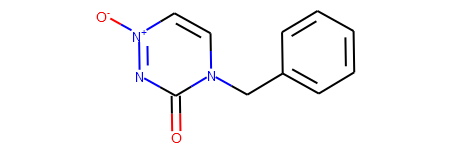

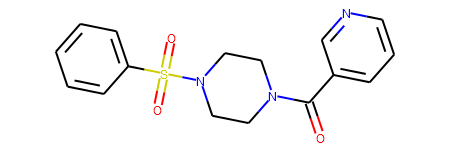

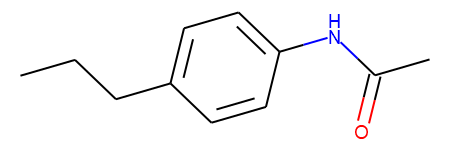

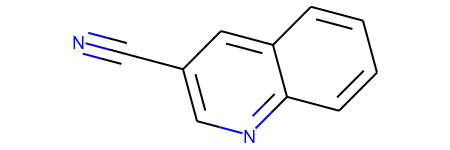

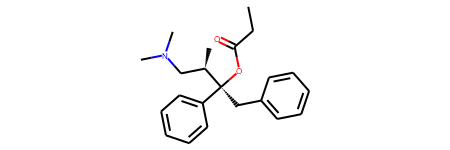

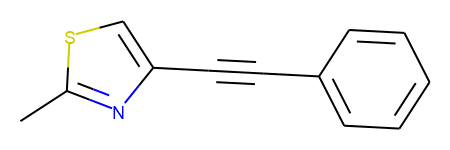

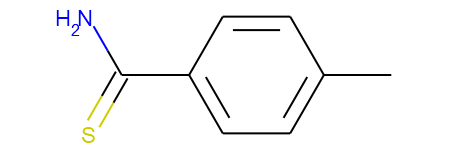

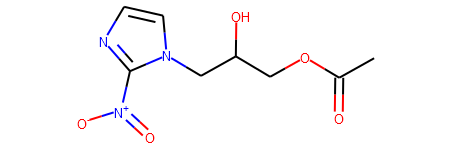

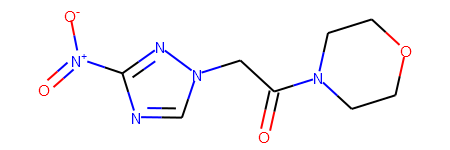

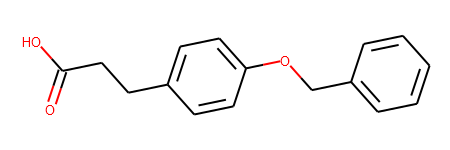

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CC(=O)Oc1ccc([N+](=O)[O-])cc1,1.50,1.706478,0.042633,17,2,0,0.000000,1,50.000000,13,6,46.153846,False
1,N#Cc1cn[nH]c1,0.24,0.446889,0.042803,9,1,0,0.000000,1,100.000000,7,5,71.428571,False
2,CC1=CCCC2N=C3CCCC3C(=O)N12,1.20,1.407137,0.042906,28,3,2,7.142857,2,66.666667,17,0,0.000000,False
3,Clc1ccc(-c2cccc(Cl)c2)cc1,5.15,5.357512,0.043061,9,2,0,0.000000,0,0.000000,15,12,80.000000,False
4,O=C(O)c1cccc(I)c1,3.13,2.922016,0.043257,52,3,0,0.000000,0,0.000000,10,6,60.000000,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

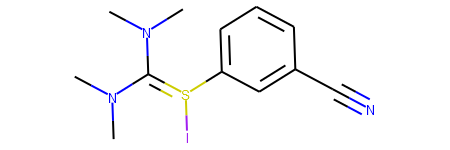

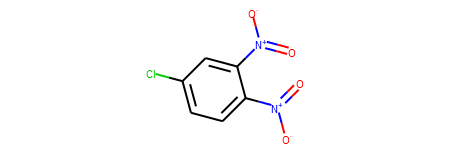

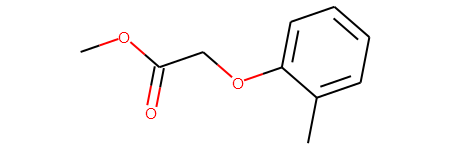

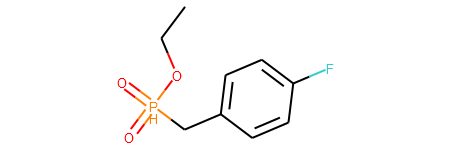

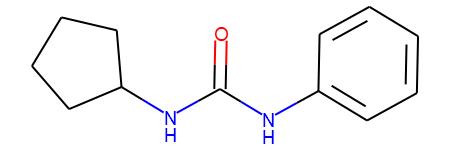

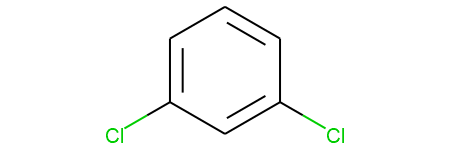

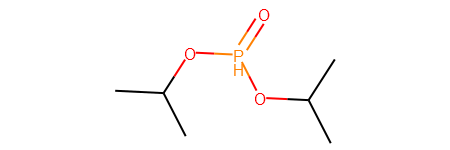

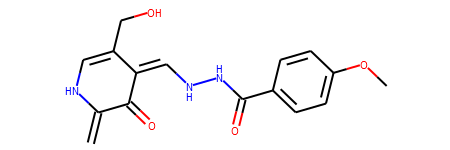

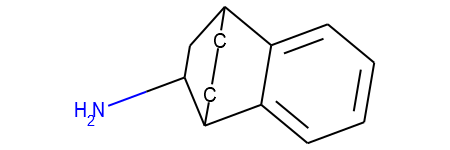

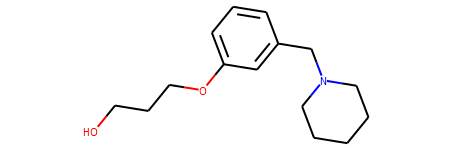

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

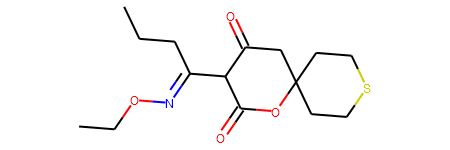

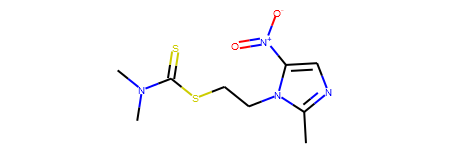

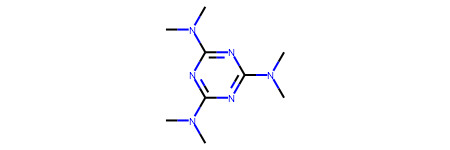

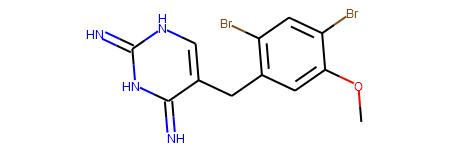

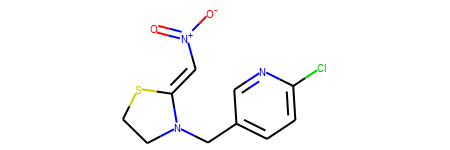

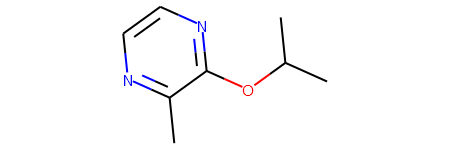

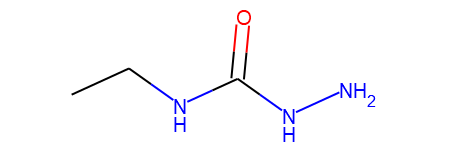

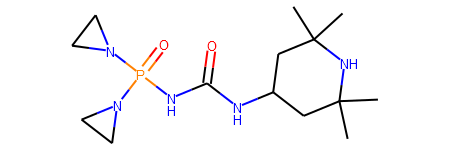

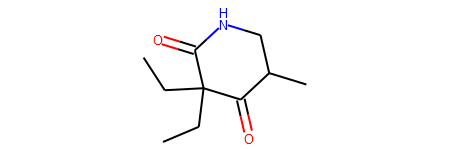

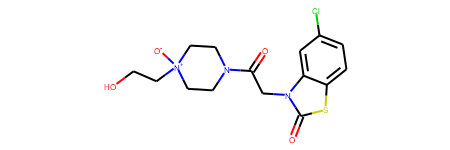

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1648,CCCC(=O)OCC(Cc1cncn1C)C(CC)C(=O)OCc1ccccc1,3.78,3.780033,1.083752e-09,25,1,5,20.000000,1,100.0,29,11,37.931034,False
1427,CC(C)C(=O)Nc1cc(Cl)ccc1S(N)(=O)=O,1.87,1.870188,3.528984e-08,29,4,2,6.896552,2,50.0,17,6,35.294118,False
1933,N#CC(=NOCC1OCCO1)c1ccccc1,2.76,2.760343,1.176452e-07,20,1,0,0.000000,1,100.0,18,6,33.333333,False
1395,CCCCC(OC(Cc1ccccc1)C(=O)N1CCC(OCOC)CC1)C(=O)NC...,4.20,4.200467,2.178578e-07,10,1,0,0.000000,0,0.0,56,6,10.714286,False
1864,CCOC(=O)CN(C(=O)CCl)c1ccccc1OC(C)C,2.75,2.749396,3.647006e-07,10,1,0,0.000000,1,100.0,21,6,28.571429,False


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
658,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,2.459563,17.889205,17,2,0,0.000000,1,50.0,74,5,6.756757,False
478,Cc1[nH]c(=O)c(CC(O)NC(Cc2cn(C(=O)OCc3ccccc3)c3...,5.66,2.019374,13.254155,18,2,1,5.555556,1,50.0,61,34,55.737705,False
223,O=C1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(...,5.41,1.893417,12.366359,26,2,0,0.000000,1,50.0,25,0,0.000000,False
1699,CCCCCCCCCCCCCCO,6.03,2.928715,9.617967,25,2,2,8.000000,0,0.0,14,0,0.000000,False
1770,Clc1c(Cl)c(Cl)c2c(oc3c(Cl)c(Cl)c(Cl)c(Cl)c32)c1Cl,8.60,5.531763,9.414080,13,1,1,7.692308,1,100.0,23,15,65.217391,True


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.007550,2.008991,1.654627e-03,17.395000,1.880000,0.930000,5.364291,0.955000,54.375000,17.030000,7.815000,46.792888
std,1.387093,1.389958,1.388394e-03,7.349083,1.180069,1.365438,7.669070,0.731883,40.435043,7.212433,4.289847,19.794715
min,-2.280000,-2.336590,1.083752e-09,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.207500,1.200497,3.538231e-04,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,35.714286
50%,2.005000,1.984349,1.481110e-03,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,47.809524
75%,2.752500,2.768566,2.810451e-03,20.000000,3.000000,1.000000,7.852564,1.000000,100.000000,20.000000,11.000000,60.000000
max,6.440000,6.478714,4.564900e-03,58.000000,8.000000,8.000000,38.888889,3.000000,100.000000,56.000000,30.000000,100.000000


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,2.759100,2.441754,3.136872,17.950000,1.855000,0.910000,5.889778,0.910000,48.725000,22.63500,8.450000,36.712298
std,2.657333,1.863337,2.272780,7.446121,1.237592,1.404193,10.304941,0.809429,40.282703,11.50188,7.154961,26.912294
min,-3.700000,-2.096941,1.289940,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.00000,0.000000,0.000000
25%,0.917500,1.362175,1.687825,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.00000,5.000000,7.737576
50%,3.070000,2.387096,2.287337,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,20.00000,6.000000,40.000000
75%,4.632500,3.545551,3.892101,21.000000,2.000000,1.000000,8.522727,1.000000,100.000000,27.25000,12.000000,58.254269
max,8.600000,7.577138,17.889205,54.000000,6.000000,8.000000,80.000000,4.000000,100.000000,74.00000,36.000000,100.000000


### Check atom_count influence

In [42]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-0.7502269666231712, pvalue=0.45356128838974263)


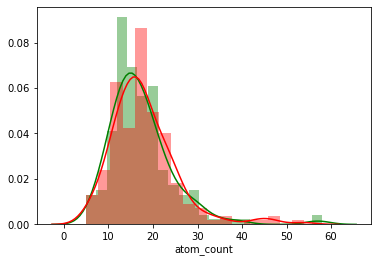

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=0.2067529755928338, pvalue=0.8363085140450774)


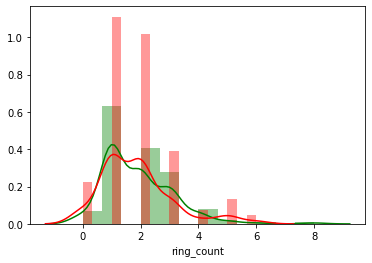

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.1444093967857027, pvalue=0.885250292228686)


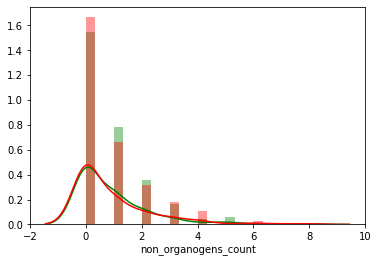

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=-0.5785315908973581, pvalue=0.5632325000692938)


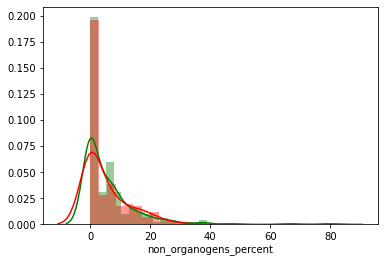

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=0.5831802179247441, pvalue=0.5601022815521629)


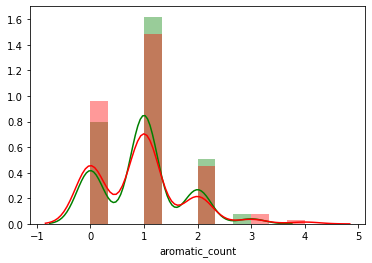

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=1.3999374907161781, pvalue=0.16231103903938285)


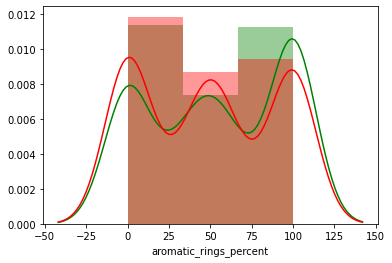

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=4.267258454098921, pvalue=2.4759282241859253e-05)


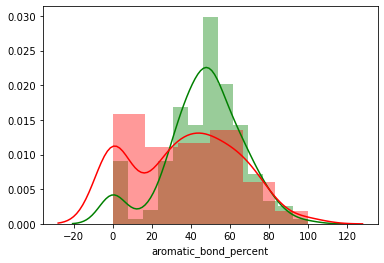

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-1.0764547631324053, pvalue=0.28237598649553347)


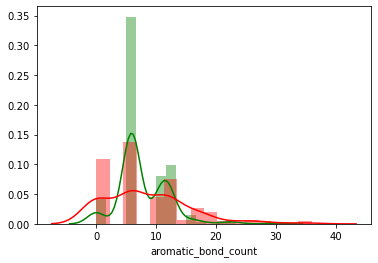

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

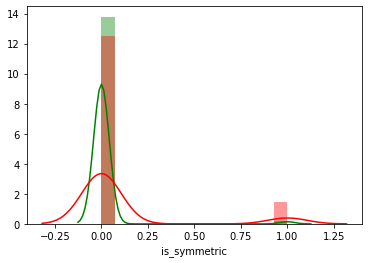

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [69]:
X_test_mol = [Chem.MolFromSmiles(x) for x in compare_data.smiles]

In [70]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [71]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [72]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [73]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [74]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [75]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 1.2003714573002118
Test symmetric R2-score is 0.7280120611550465


In [76]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.6984671855396036
Test not symmetric R2-score is 0.8507005282146682
